# figures_draft2017a.ipynb

## Purpose
Produce figures and supplementary figures for *"Radiative effects of anthropogenic aerosol emissions from different source regions"*.

## Additional supplementary figures
Some additional supplementary figures are produced by [emissions_bug_draft2017a.ipynb](https://github.com/grandey/draft2017a-region-rfp/blob/master/emissions_bug_draft2017a.ipynb).

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2017a.py](https://github.com/grandey/draft2017a-region-rfp/blob/master/lib_draft2017a.py) 

## Data requirements
CESM output data, post-processed to time-series format, as described in [data_management.org](https://github.com/grandey/draft2017a-region-rfp/blob/master/data_management.org#syncing-to-local-machine-for-analysis). These data will also be uploaded to figshare.

## Author
Benjamin S. Grandey, 2017

In [1]:
! date

Thu Dec 28 17:53:01 +08 2017


In [2]:
import climapy
import lib_draft2017a
import ipywidgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
from scipy import stats
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2017a.py is using {}'.format(lib_draft2017a.dependency_versions()))

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.13.3
pandas.__version__ = 0.21.0
xarray.__version__ = 0.10.0
lib_draft2017a.py is using {'climapy': '0.1.0+b35937c', 'pandas': '0.21.0', 'xarray': '0.10.0'}


In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures
plt.rcParams['axes.titlepad'] = 15  # increase distance to title

In [4]:
# Load dictionaries etc from lib_draft2017a
region_bounds_dict = lib_draft2017a.load_region_bounds_dict()
region_long_dict = lib_draft2017a.load_region_long_dict()
scenario_name_dict = lib_draft2017a.load_scenario_name_dict()
variable_long_dict = lib_draft2017a.load_variable_long_dict()
variable_symbol_dict = lib_draft2017a.load_variable_symbol_dict()
variable_units_dict = lib_draft2017a.load_variable_units_dict()

In [5]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supp_figure_counter = 1  # supplementary figures

## Map of regions

Written local/f01.pdf


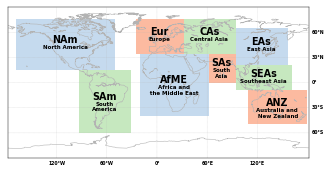

In [6]:
# Load sample data
sample_data = lib_draft2017a.load_output('BURDENSO4', scenario='p16a_F_Hist_2000',
                                         season='annual').isel(year=0).copy()
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-179)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
# Set-up plot
fig = plt.figure(figsize=(8.0, 6.0))
bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=lon0+360.0)
bm.drawcoastlines(color='0.7')
bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
# Plot region masks and names
for region, region_bounds in region_bounds_dict.items():
    lon_bounds, lat_bounds = region_bounds
    # Get long name of region
    long_name = region_long_dict[region]
    if region in ['SAm', 'SAs']:  # split long name over two lines if necessary
        long_name = '\n'.join(long_name.split(' '))
    if region in ['AfME', 'ANZ']:
        long_name = 'and\n'.join(long_name.split('and'))
    # Set colour map
    if region in ['NAm', 'AfME', 'EAs']:  # shading colour dependent on region
        cmap = 'Blues'
    elif region in ['SAm', 'CAs', 'SEAs']:
        cmap = 'Greens'
    else:
        cmap = 'Reds'
    # Create data for region using sample_data
    region_data = sample_data.copy()
    region_data = climapy.xr_mask_bounds(region_data, select_how='inside',  # mask
                                         lon_bounds=lon_bounds, lat_bounds=lat_bounds)
    # Plot data and annotations
    if lon_bounds is not None:
        plt.imshow(region_data, extent=[lon0, 360+lon0, -lat0, lat0],
                   interpolation='Nearest', cmap=cmap,
                   vmin=0, vmax=4)
        label_pos = [(lon_bounds[0]+lon_bounds[1])/2,
                     (lat_bounds[0]+lat_bounds[1])/2]
        plt.text(label_pos[0], label_pos[1], region,  # short name
                 color='k', weight='bold', fontsize='xx-large',
                 horizontalalignment='center', verticalalignment='bottom')
        plt.text(label_pos[0], label_pos[1], long_name,  # long name
                 color='k', weight='bold',
                 horizontalalignment='center', verticalalignment='top')
# Save figure
fig.tight_layout()
plt.savefig('local/f{:02}.pdf'.format(figure_counter), bbox_inches='tight', dpi=300)
print('Written local/f{:02}.pdf'.format(figure_counter))
figure_counter += 1

## Load global emissions data

In [7]:
# Load global emissions for different scenarios into dataframe
global_emissions_df = pd.DataFrame(columns=('scenario', 'scenario_name',
                                            'species', 'global_total'))
# Loop over scenarios and variables
for scenario, scenario_name in scenario_name_dict.items():
    # Load emissions for organic carbon (g/m2/yr)
    oc_both = lib_draft2017a.load_emissions('oc', 'both', scenario=scenario[7:])
    # Load emissions for black carbon (g/m2/yr)
    bc_both = lib_draft2017a.load_emissions('bc', 'both', scenario=scenario[7:])
    # Load emissions for sulphur species (g(S)/m2/yr)
    so2_both = lib_draft2017a.load_emissions('so2', 'both', scenario=scenario[7:])
    so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario[7:])
    if scenario[0:6] == 'p17b_F':  # intended so4_a2 emissions
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario[7:])
    else:  # due to bug
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario[7:])
    dms = lib_draft2017a.load_emissions('dms', 'both')
    # Sum emissions for sulphur species
    s_both = so2_both + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev + dms
    # Calculate global totals (Tg/yr)
    s_global = climapy.xr_area_weighted_stat(s_both, stat='sum').values / 1e12
    oc_global = climapy.xr_area_weighted_stat(oc_both, stat='sum').values / 1e12
    bc_global = climapy.xr_area_weighted_stat(bc_both, stat='sum').values / 1e12
    # Store global totals in dataframe
    for species, global_total in zip(['S', 'OC', 'BC'], [s_global, oc_global, bc_global]):
        global_emissions_df = global_emissions_df.append({'scenario': scenario, 
                                                          'scenario_name': scenario_name,
                                                          'species': species,
                                                          'global_total': global_total},
                                                         ignore_index=True)
    # Close data arrays
    for da in [oc_both, bc_both, so2_both, so4_a1_surf, so4_a1_elev,
               so4_a2_surf, so4_a2_elev, dms]:
        da.close()

global_emissions_df.head()

,scenario,scenario_name,species,global_total
0,p16a_F_Hist_2000,All1,S,84.596255
1,p16a_F_Hist_2000,All1,OC,35.889499
2,p16a_F_Hist_2000,All1,BC,7.758681
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555


In [8]:
# Print emissions for All0
global_emissions_df[(global_emissions_df['scenario_name'] == 'All0')]

,scenario,scenario_name,species,global_total
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555
5,p16a_F_Zero_2000,All0,BC,2.608787


In [9]:
# For emissions, calculate differences from reference scenarios
def diff_according_to_scenario_name_for_emissions(row):
    """
    For emissions, calculate difference according to scenario name.
    
    Args:
        row: row of the global_emissions_df DataFrame.
    
    Returns:
        Modified version of row containing 'scenario_diff' and 'global_diff'.
    """
    scenario_name = row['scenario_name']
    if scenario_name[-1] == '1':  # if ends with '1', compare to All0
        ref_name = 'All0'
    else:  # if ends with '0', compare to All1
        ref_name = 'All1'
    ref_row = global_emissions_df[(global_emissions_df['species'] == row['species']) &
                                  (global_emissions_df['scenario_name'] == ref_name)
                                 ].T.squeeze()  # DataFrame to Series
    if ref_name == 'All0':
        scenario_diff = '{}-All0'.format(scenario_name)
        global_diff = row['global_total'] - ref_row['global_total']
    else:
        scenario_diff = 'All1-{}'.format(scenario_name)
        global_diff = ref_row['global_total'] - row['global_total']
    row['ref_name'] = ref_name
    row['scenario_diff'] = scenario_diff
    row['global_diff'] = global_diff
    return row

diff_emissions_df = global_emissions_df.apply(diff_according_to_scenario_name_for_emissions,
                                              axis=1)  # apply function above
diff_emissions_df.head()

,scenario,scenario_name,species,global_total,ref_name,scenario_diff,global_diff
0,p16a_F_Hist_2000,All1,S,84.596255,All0,All1-All0,51.878029
1,p16a_F_Hist_2000,All1,OC,35.889499,All0,All1-All0,12.700944
2,p16a_F_Hist_2000,All1,BC,7.758681,All0,All1-All0,5.149895
3,p16a_F_Zero_2000,All0,S,32.718225,All1,All1-All0,51.878029
4,p16a_F_Zero_2000,All0,OC,23.188555,All1,All1-All0,12.700944


## Emissions barcharts

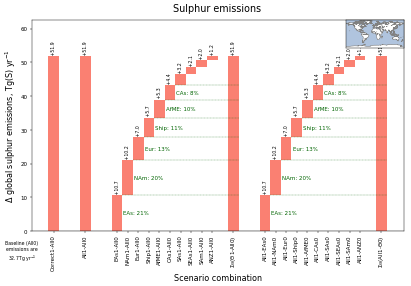

In [10]:
# Function to produce staggered barcharts for a given emissions species
def emissions_staggered_barcharts(species='S', title='Sulphur emissions',
                                  ylabel=r'$\Delta$ global sulphur emissions, Tg(S) yr$^{-1}$',
                                  text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                                  map_insert=True, ylim=None,
                                  n_contributors='auto',
                                  file_prefix=None):
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 7))
    # Get subset of relevant data from diff_emissions_df
    bars_df = diff_emissions_df[(diff_emissions_df['species'] == species)]
    # Delete repeat of All1-All0
    bars_df = bars_df[(bars_df['scenario_name'] != 'All0') | (bars_df['ref_name'] != 'All1')]
    # Set scenario_diff as index, after changing dtype to object (to facilitate easier appending)
    bars_df['scenario_diff'] = bars_df['scenario_diff'].astype('object')
    bars_df = bars_df.set_index('scenario_diff')
    # Add 'bottom' column and 'x' position column, both initialised as NaNs
    bars_df = bars_df.assign(bottom=np.nan, x=np.nan)
    # x position and bottom for first two bars
    bars_df.loc['Correct1-All0', 'x'] = 0  # 1st bar
    bars_df.loc['Correct1-All0', 'bottom'] = 0
    bars_df.loc['All1-All0', 'x'] = 3  # 2nd bar
    bars_df.loc['All1-All0', 'bottom'] = 0
    # 1st set of staggered bars
    order1 = (bars_df[(bars_df['ref_name'] == 'All0') &  # order <Source>1-All0 by global_diff
                      (bars_df['scenario_name'] != 'All1') &
                      (bars_df['scenario_name'] != 'Correct1')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order1, 'x'] = np.arange(len(order1)) + max(bars_df['x']) + 3
    for i in (range(len(order1))):
        if i == 0:
            bars_df.loc[order1[i], 'bottom'] = 0
        else:
            bars_df.loc[order1[i], 'bottom'] = (bars_df.loc[order1[i-1], 'bottom'] +
                                                bars_df.loc[order1[i-1], 'global_diff'])
    # 1st combined bar
    global_diff = bars_df.loc[order1, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$($\Theta$1-All0)'))
    # 2nd set of staggered bars
    order2 = (bars_df[(bars_df['ref_name'] == 'All1') &  # order All1-<Source>0 by global_diff
                      (bars_df['scenario_name'] != 'All0')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order2, 'x'] = np.arange(len(order2)) + max(bars_df['x']) + 3
    for i in (range(len(order2))):
        if i == 0:
            bars_df.loc[order2[i], 'bottom'] = 0
        else:
            bars_df.loc[order2[i], 'bottom'] = (bars_df.loc[order2[i-1], 'bottom'] +
                                                bars_df.loc[order2[i-1], 'global_diff'])
    # 2nd combined bar
    global_diff = bars_df.loc[order2, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$(All1-$\Theta$0)'))
    # Add colour based on whether -ve or +ve
    bars_df = bars_df.assign(color='salmon')  # all bars are +ve
    # Plot barchart
    ax.bar(bars_df['x'], bars_df['global_diff'], bottom=bars_df['bottom'],
           width=1., color=bars_df['color'])
    # Axes and title
    plt.axhline(y=0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xticks(bars_df['x'])
    ax.set_xticklabels(bars_df.index, rotation=90)
    ax.set_xlabel('Scenario combination', fontsize='x-large')
    ax.set_ylabel(ylabel, fontsize='x-large')
    if ylim:
        ax.set_ylim(ylim)
    else:  # stretch y-axis to accommodate annotations
        ax.set_ylim([y * 1.15 for y in ax.get_ylim()])
    ax.set_title(title, fontsize='xx-large')
    # Annotate with values
    for scenario in bars_df.index:
        text = text_format.format(bars_df.loc[scenario, 'global_diff'])
        if bars_df.loc[scenario, 'global_diff'] > 0:
            verticalalignment='bottom'
        else:
            verticalalignment='top'
        ax.text(bars_df.loc[scenario, 'x'], bars_df.loc[scenario, ['bottom', 'global_diff']].sum(),
                text, rotation=90, verticalalignment=verticalalignment,
                horizontalalignment='center', fontsize='small')
    # Annotate combined bars with largest contributing sources
    for scenario, order, ref_name in zip([r'$\Sigma_{\Theta}$($\Theta$1-All0)',
                                          r'$\Sigma_{\Theta}$(All1-$\Theta$0)'],
                                         [order1, order2], ['All0', 'All1']):
        if n_contributors == 'auto':
            n = 0  
            perc_sum = 0  # % contribution accounted for so far
            for s in order:
                perc_sum += bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100
                if perc_sum > 100 or perc_sum < 0:
                    break
                elif perc_sum > 80:
                    n += 1
                    break
                else:
                    n += 1
        else:
            n = n_contributors
        for s in order[0:n]:
            y_pos = bars_df.loc[s, ['global_diff', 'bottom']].sum()
            ax.plot([bars_df.loc[s, 'x']+0.5, bars_df.loc[scenario, 'x']+0.5],  # draw horizontal line
                    [y_pos, y_pos], color='darkgreen', linestyle='--', linewidth=0.5)
            perc = bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100  # % contribution
            if ref_name == 'All1':
                source = s.split('-')[1][:-1]
            else:
                source = s.split('-')[0][:-1]
            text = '{}: {:.0f}%'.format(source, perc)
            text_y_pos = bars_df.loc[s, 'bottom'] + (bars_df.loc[s, 'global_diff'] / 2)
            ax.text(bars_df.loc[s, 'x']+0.6, text_y_pos, text,
                    verticalalignment='center', horizontalalignment='left',
                    color='darkgreen')
    # Annotate with All0 baseline
    all0_baseline = global_emissions_df[(global_emissions_df['scenario_name'] == 'All0') &
                                        (global_emissions_df['species'] == species)
                                       ]['global_total']
    ax.text(-3, 0, ('\n\nBaseline (All0)\nemissions are\n' +
                    baseline_text_format.format(float(all0_baseline)) +
                    'Tg yr$^{-1}$'),
            fontsize='small',
            horizontalalignment='center', verticalalignment='top')
    # Insert map
    if map_insert:
        ax2 = plt.axes([0.78, 0.76, .12, .12], facecolor='lightsteelblue')
        anchor = 'NE'
        lon_bounds = [lon0, lon0+360.]
        lat_bounds = [-90.0, 90.0]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    # Save figure?
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig, ax

# Example
if True:
    fig, ax = emissions_staggered_barcharts()

Written local/fS01.pdf


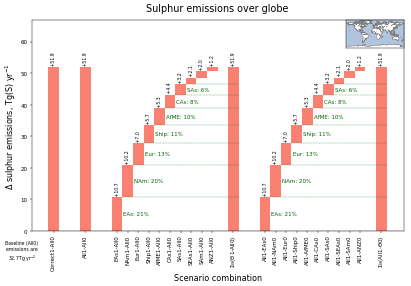

In [11]:
# Global sulphur emissions - supp figure
emissions_staggered_barcharts(species='S',
                              title='Sulphur emissions over globe',
                              ylabel=r'$\Delta$ sulphur emissions, Tg(S) yr$^{-1}$',
                              text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                              ylim=[0, 67], n_contributors=7,
                              file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS02.pdf


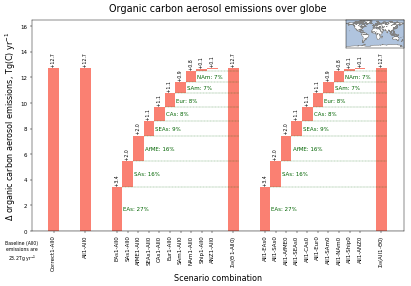

In [12]:
# Global organic carbon aerosol emissions - supp figure
emissions_staggered_barcharts(species='OC',
                              title='Organic carbon aerosol emissions over globe',
                              ylabel=(r'$\Delta$ organic carbon aerosol '
                                      'emissions, Tg(C) yr$^{-1}$'),
                              text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                              ylim=[0, 16.5], n_contributors=8,
                              file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS03.pdf


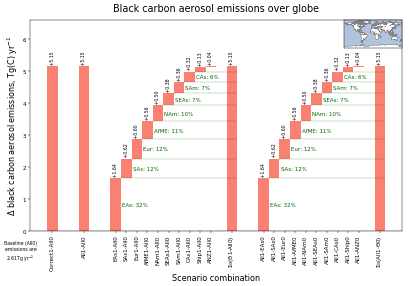

In [13]:
# Global black carbon aerosol emissions - supp figure
emissions_staggered_barcharts(species='BC', title='Black carbon aerosol emissions over globe',
                             ylabel=(r'$\Delta$ black carbon aerosol '
                                     'emissions, Tg(C) yr$^{-1}$'),
                             text_format=r' {:+.2f}', baseline_text_format='{:.2f}',
                             ylim=[0, 6.6], n_contributors=8,
                             file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

## Load model output data and calculate regional statistics

In [14]:
# DataFrame to hold regional means and errors
regional_df = pd.DataFrame(columns=('variable', 'region', 'scenario',
                                    'scenario_name', 'awms', 'mean', 'error', 'n_years'))
# Progress bar and text
progress_bar = ipywidgets.IntProgress(min=0,
                                      max=(len(scenario_name_dict) * len(variable_long_dict) *
                                           len(region_bounds_dict)),
                                      description='Progress')
display(progress_bar)
progress_text = ipywidgets.Text(description='Loading')
display(progress_text)
# Loop over scenarios and variables
for scenario, scenario_name in scenario_name_dict.items():
    for variable in variable_long_dict.keys():
        # Load annual data
        if '+' in variable:
            variable1, variable2 = variable.split('+')
            da = (lib_draft2017a.load_output(variable1, scenario=scenario,
                                             season='annual', apply_sf=True) +
                  lib_draft2017a.load_output(variable2, scenario=scenario,
                                             season='annual', apply_sf=True))
        elif '-' in variable:
            variable1, variable2 = variable.split('-')
            da = (lib_draft2017a.load_output(variable1, scenario=scenario,
                                             season='annual', apply_sf=True) -
                  lib_draft2017a.load_output(variable2, scenario=scenario,
                                             season='annual', apply_sf=True))
        else:
            da = lib_draft2017a.load_output(variable, scenario=scenario,
                                            season='annual', apply_sf=True)
        # Loop over regions
        for region, bounds in region_bounds_dict.items():
            lon_bounds, lat_bounds = bounds
            progress_text.value = '{}, {}, {}'.format(scenario, variable, 
                                                      region)  # update progress text
            # Calculate regional mean for each year etc
            awms = climapy.xr_area_weighted_stat(da, stat='mean', lon_bounds=lon_bounds,
                                                 lat_bounds=lat_bounds)
            nyears = awms.values.size
            mean = awms.values.mean()  # mean
            error = np.std(awms.values, ddof=1) / np.sqrt(nyears)  # standard error of the mean
            # Store awms, mean and standard error in DataFrame
            regional_df = regional_df.append({'variable': variable, 'region': region,
                                              'scenario': scenario, 'scenario_name': scenario_name,
                                              'awms': awms,
                                              'mean': mean, 'error': error,
                                              'n_years': nyears},
                                              ignore_index=True)
            progress_bar.value += 1  # update progress bar value
        da.close()  # close DataArray
progress_text.value = 'Complete' # update progress bar text

IntProgress(value=0, description='Progress', max=2530)

Text(value='', description='Loading')

In [15]:
regional_df.info()
regional_df['n_years'] = regional_df['n_years'].astype('int')  # object -> int
regional_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 8 columns):
variable         2530 non-null object
region           2530 non-null object
scenario         2530 non-null object
scenario_name    2530 non-null object
awms             2530 non-null object
mean             2530 non-null float64
error            2530 non-null float64
n_years          2530 non-null object
dtypes: float64(2), object(6)
memory usage: 158.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 8 columns):
variable         2530 non-null object
region           2530 non-null object
scenario         2530 non-null object
scenario_name    2530 non-null object
awms             2530 non-null object
mean             2530 non-null float64
error            2530 non-null float64
n_years          2530 non-null int64
dtypes: float64(2), int64(1), object(5)
memory usage: 158.2+ KB


In [16]:
regional_df.head()

,variable,region,scenario,scenario_name,awms,mean,error,n_years
0,FSNTOA+LWCF,EAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(234.981719559152...,236.756086,0.125602,60
1,FSNTOA+LWCF,SEAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(338.301912119021...,338.728198,0.086329,60
2,FSNTOA+LWCF,ANZ,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(290.453715731387...,290.767015,0.092900,60
3,FSNTOA+LWCF,SAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(322.112187316865...,322.470404,0.120270,60
4,FSNTOA+LWCF,AfME,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(303.831621556001...,304.000680,0.056877,60


In [17]:
regional_df.groupby('variable')[['mean', 'n_years']].describe(percentiles=[0.5, ])

mean                                                 \
                  count        mean        std         min         50%   
variable                                                                 
AEROD_v           230.0    0.113301   0.044566    0.071051    0.102530   
BURDENBC          230.0    0.161671   0.131396    0.014275    0.113210   
BURDENPOM         230.0    1.226645   0.811470    0.211371    1.055710   
BURDENSO4         230.0    2.642088   1.819434    0.617877    1.951921   
FSNTOA+LWCF       230.0  272.043623  43.813344  201.375717  277.798420   
FSNTOA-FSNTOA_d1  230.0   -1.404228   0.398882   -2.049601   -1.518532   
FSNTOAC_d1        230.0  302.106533  47.912602  215.582389  310.407963   
LWCF              230.0   26.636972   8.783189   17.106781   23.869039   
SWCF_d1           230.0  -55.295653  13.383709  -84.365835  -53.789217   
TGCLDIWP          230.0   19.675361   4.133041   13.741543   19.833569   
TGCLDLWP          230.0   47.232565  11.692836   18.606276   47.748645   

                             n_years                                          
                         max   count       mean        std   min   50%   max  
variable                                                                      
AEROD_v             0.248710   230.0  33.913043  10.125471  30.0  30.0  60.0  
BURDENBC            0.456846   230.0  33.913043  10.125471  30.0  30.0  60.0  
BURDENPOM           3.309774   230.0  33.913043  10.125471  30.0  30.0  60.0  
BURDENSO4           6.151038   230.0  33.913043  10.125471  30.0  30.0  60.0  
FSNTOA+LWCF       341.108614   230.0  33.913043  10.125471  30.0  30.0  60.0  
FSNTOA-FSNTOA_d1   -0.657081   230.0  33.913043  10.125471  30.0  30.0  60.0  
FSNTOAC_d1        374.227702   230.0  33.913043  10.125471  30.0  30.0  60.0  
LWCF               49.995623   230.0  33.913043  10.125471  30.0  30.0  60.0  
SWCF_d1           -27.089209   230.0  33.913043  10.125471  30.0  30.0  60.0  
TGCLDIWP           25.543569   230.0  33.913043  10.125471  30.0  30.0  60.0  
TGCLDLWP           68.163087   230.0  33.913043  10.125471  30.0  30.0  60.0

## Calculate differences from reference scenarios

In [18]:
def diff_according_to_scenario_name(row):
    """Calculate difference according to scenario name.
    
    Args:
        row: row of the regional_df DataFrame.
    
    Returns:
        Modified version of row containing 'scenario_diff', 'mean_diff',
        'combined_error', and 'p_value'.
    """
    scenario_name = row['scenario_name']
    if scenario_name[-1] == '1':  # if ends with '1', compare to All0
        ref_name = 'All0'
    else:  # if ends with '0', compare to All1
        ref_name = 'All1'
    ref_row = regional_df[(regional_df['variable'] == row['variable']) &  # row corresponding to ref scenario
                          (regional_df['region'] == row['region']) &
                          (regional_df['scenario_name'] == ref_name)].T.squeeze()  # DataFrame to Series
    if ref_name == 'All0':
        scenario_diff = '{}-All0'.format(scenario_name)
        mean_diff = row['mean'] - ref_row['mean']
    else:
        scenario_diff = 'All1-{}'.format(scenario_name)
        mean_diff = ref_row['mean'] - row['mean']
    combined_error = np.sqrt(row['error']**2 + ref_row['error']**2)
    p_value = stats.ttest_ind(ref_row['awms'], row['awms'],
                              equal_var=False)[1]  # Welch's t-test
    row['ref_name'] = ref_name
    row['scenario_diff'] = scenario_diff
    row['mean_diff'] = mean_diff
    row['combined_error'] = combined_error
    row['p_value'] = p_value
    return row

# Apply function above
diff_df = regional_df.apply(diff_according_to_scenario_name, axis=1)
diff_df.head()

,variable,region,scenario,scenario_name,awms,mean,error,n_years,ref_name,scenario_diff,mean_diff,combined_error,p_value
0,FSNTOA+LWCF,EAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(234.981719559152...,236.756086,0.125602,60,All0,All1-All0,-5.556919,0.162496,1.157682e-61
1,FSNTOA+LWCF,SEAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(338.301912119021...,338.728198,0.086329,60,All0,All1-All0,-2.186222,0.131377,1.698391e-32
2,FSNTOA+LWCF,ANZ,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(290.453715731387...,290.767015,0.092900,60,All0,All1-All0,-1.019759,0.140561,4.870559e-11
3,FSNTOA+LWCF,SAs,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(322.112187316865...,322.470404,0.120270,60,All0,All1-All0,-4.303220,0.163884,6.066486e-51
4,FSNTOA+LWCF,AfME,p16a_F_Hist_2000,All1,[<xarray.DataArray ()>\narray(303.831621556001...,304.000680,0.056877,60,All0,All1-All0,-2.093712,0.076267,1.055785e-52


In [19]:
# Select just columns of interest
diff_df = diff_df[['variable', 'region', 'scenario_name', 'ref_name', 'scenario_diff',
                   'mean_diff', 'combined_error', 'p_value']]
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 8 columns):
variable          2530 non-null object
region            2530 non-null object
scenario_name     2530 non-null object
ref_name          2530 non-null object
scenario_diff     2530 non-null object
mean_diff         2530 non-null float64
combined_error    2530 non-null float64
p_value           2530 non-null float64
dtypes: float64(3), object(5)
memory usage: 158.2+ KB


In [20]:
diff_df.groupby('variable')[['mean_diff']].describe()

mean_diff                                                    \
                     count      mean       std       min       25%       50%   
variable                                                                       
AEROD_v              230.0  0.004391  0.008581 -0.003399  0.000099  0.000953   
BURDENBC             230.0  0.035985  0.083291 -0.008172  0.000917  0.004822   
BURDENPOM            230.0  0.130998  0.313799 -0.041182  0.004011  0.020496   
BURDENSO4            230.0  0.684973  1.257201 -0.067674  0.051899  0.167368   
FSNTOA+LWCF          230.0 -0.675347  1.310433 -5.557518 -0.550376 -0.140620   
FSNTOA-FSNTOA_d1     230.0  0.000673  0.045555 -0.111480 -0.014205  0.000058   
FSNTOAC_d1           230.0 -0.008601  0.080142 -0.370813 -0.033468 -0.004163   
LWCF                 230.0  0.251892  0.591565 -0.399471 -0.013807  0.066106   
SWCF_d1              230.0 -0.919311  1.796223 -8.948943 -0.916509 -0.174040   
TGCLDIWP             230.0  0.100767  0.355049 -0.558258 -0.071714  0.037682   
TGCLDLWP             230.0  1.766982  3.693065 -0.654339 -0.036075  0.279934   

                                       
                       75%        max  
variable                               
AEROD_v           0.003214   0.038720  
BURDENBC          0.018370   0.411640  
BURDENPOM         0.061859   1.793076  
BURDENSO4         0.457492   5.069607  
FSNTOA+LWCF       0.010641   0.721685  
FSNTOA-FSNTOA_d1  0.010945   0.268908  
FSNTOAC_d1        0.012246   0.312277  
LWCF              0.274220   4.341067  
SWCF_d1           0.026875   0.719465  
TGCLDIWP          0.203075   2.426726  
TGCLDLWP          1.252480  17.865855

In [21]:
diff_df.groupby('variable')[['p_value']].describe()

p_value                                                   \
                   count      mean       std            min           25%   
variable                                                                    
AEROD_v            230.0  0.266090  0.321524   3.284884e-91  1.307842e-07   
BURDENBC           230.0  0.138643  0.251111  1.093289e-152  7.832357e-38   
BURDENPOM          230.0  0.187984  0.277996  1.319395e-131  2.807218e-16   
BURDENSO4          230.0  0.067893  0.187054  5.768204e-131  4.500727e-44   
FSNTOA+LWCF        230.0  0.292157  0.321519  9.360116e-100  3.330927e-06   
FSNTOA-FSNTOA_d1   230.0  0.328179  0.320419   2.380899e-60  3.440654e-02   
FSNTOAC_d1         230.0  0.404570  0.309618   6.577779e-05  1.229239e-01   
LWCF               230.0  0.326531  0.329315   5.100086e-78  1.155928e-03   
SWCF_d1            230.0  0.284127  0.322725  5.746815e-120  6.215347e-08   
TGCLDIWP           230.0  0.346059  0.312358   4.431795e-22  5.621563e-02   
TGCLDLWP           230.0  0.268617  0.309710  1.027299e-116  5.256620e-10   

                                                    
                           50%       75%       max  
variable                                            
AEROD_v           1.037826e-01  0.515340  0.995941  
BURDENBC          3.543186e-07  0.163084  0.980726  
BURDENPOM         5.248278e-03  0.325518  0.991090  
BURDENSO4         3.123852e-20  0.000624  0.985347  
FSNTOA+LWCF       1.748234e-01  0.551980  0.998835  
FSNTOA-FSNTOA_d1  2.127878e-01  0.586054  0.995724  
FSNTOAC_d1        3.140000e-01  0.666579  0.993022  
LWCF              2.361764e-01  0.604366  0.990981  
SWCF_d1           1.545187e-01  0.576306  0.997227  
TGCLDIWP          2.567240e-01  0.612444  0.992538  
TGCLDLWP          1.511259e-01  0.493708  0.999033

## Staggered barcharts of model output

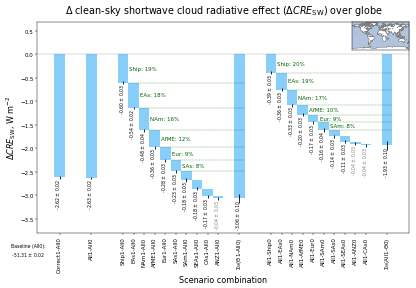

In [22]:
# Function to produce staggered barcharts for a given variable and region
def staggered_barcharts(variable='SWCF_d1', region='EAs',
                        text_format=r' {:+.2f} $\pm$ {:.2f} ',
                        ylim=None,
                        n_contributors='auto',
                        map_insert=True,
                        correct1_bar=True,
                        file_prefix=None):
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 7))
    # Get subset of relevant data from diff_df
    bars_df = diff_df[(regional_df['variable'] == variable) & (diff_df['region'] == region)]
    # Delete repeat of All1-All0
    bars_df = bars_df[(bars_df['scenario_name'] != 'All0') | (bars_df['ref_name'] != 'All1')]
    # Delete Correct1-All0?
    if not correct1_bar:
        bars_df = bars_df[(bars_df['scenario_name'] != 'Correct1')]
    # Identify whether values generally positive or negative - used for sorting data etc
    if bars_df['mean_diff'].mean() > 0:
        pos_or_neg = 1
    else:
        pos_or_neg = -1
    # Set scenario_diff as index, after changing dtype to object (to facilitate easier appending)
    bars_df['scenario_diff'] = bars_df['scenario_diff'].astype('object')
    bars_df = bars_df.set_index('scenario_diff')
    # Add 'bottom' column and 'x' position column, both initialised as NaNs
    bars_df = bars_df.assign(bottom=np.nan, x=np.nan)
    # x position and bottom for first one or two bars
    if correct1_bar:
        bars_df.loc['Correct1-All0', 'x'] = 0
        bars_df.loc['Correct1-All0', 'bottom'] = 0
    bars_df.loc['All1-All0', 'x'] = 3
    bars_df.loc['All1-All0', 'bottom'] = 0
    # 1st set of staggered bars
    order1 = (bars_df[(bars_df['ref_name'] == 'All0') &  # order <Source>1-All0 by mean_diff
                      (bars_df['scenario_name'] != 'All1') &
                      (bars_df['scenario_name'] != 'Correct1')].
              sort_values(by='mean_diff', ascending=(pos_or_neg < 0)).index)
    bars_df.loc[order1, 'x'] = np.arange(len(order1)) + max(bars_df['x']) + 3
    for i in (range(len(order1))):
        if i == 0:
            bars_df.loc[order1[i], 'bottom'] = 0
        else:
            bars_df.loc[order1[i], 'bottom'] = (bars_df.loc[order1[i-1], 'bottom'] +
                                                bars_df.loc[order1[i-1], 'mean_diff'])
    # 1st combined bar
    mean_diff = bars_df.loc[order1, 'mean_diff'].sum()
    combined_error = np.sqrt((bars_df.loc[order1, 'combined_error']**2).sum())
    p_value = np.nan  # I think Fisher/Stouffer methods are inappropriate here
    bars_df = bars_df.append(pd.Series({'mean_diff': mean_diff,
                                        'combined_error': combined_error,
                                        'p_value': p_value,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$($\Theta$1-All0)'))
    # 2nd set of staggered bars
    order2 = (bars_df[(bars_df['ref_name'] == 'All1') &  # order All1-<Source>0 by mean_diff
                      (bars_df['scenario_name'] != 'All0')].
              sort_values(by='mean_diff', ascending=(pos_or_neg < 0)).index)
    bars_df.loc[order2, 'x'] = np.arange(len(order2)) + max(bars_df['x']) + 3
    for i in (range(len(order2))):
        if i == 0:
            bars_df.loc[order2[i], 'bottom'] = 0
        else:
            bars_df.loc[order2[i], 'bottom'] = (bars_df.loc[order2[i-1], 'bottom'] +
                                                bars_df.loc[order2[i-1], 'mean_diff'])
    # 2nd combined bar
    mean_diff = bars_df.loc[order2, 'mean_diff'].sum()
    combined_error = np.sqrt((bars_df.loc[order2, 'combined_error']**2).sum())
    p_value = np.nan
    bars_df = bars_df.append(pd.Series({'mean_diff': mean_diff,
                                        'combined_error': combined_error,
                                        'p_value': p_value,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$(All1-$\Theta$0)'))
    # Add colour based on whether -ve or +ve
    bars_df = bars_df.assign(color='salmon')  # assume all +ve
    w_neg = bars_df[bars_df['mean_diff'] < 0].index
    bars_df.loc[w_neg, 'color'] = 'lightskyblue'
    # Plot barchart
    ax.bar(bars_df['x'], bars_df['mean_diff'], yerr=bars_df['combined_error'],
           bottom=bars_df['bottom'], width=1., color=bars_df['color'])
    # Axes and title
    plt.axhline(y=0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xticks(bars_df['x'])
    ax.set_xticklabels(bars_df.index, rotation=90)
    ax.set_xlabel('Scenario combination', fontsize='x-large')
    if variable_units_dict[variable]:
        ylabel = '{}, {}'.format(variable_symbol_dict[variable],
                                 variable_units_dict[variable])
    else:
        ylabel = '{}'.format(variable_symbol_dict[variable])
    ax.set_ylabel(ylabel, fontsize='x-large')
    if ylim:
        ax.set_ylim(ylim)
    else:  # stretch y-axis to accommodate annotations
        ax.set_ylim([y * 1.15 for y in ax.get_ylim()])
    title = '{} ({}) over {}'.format(variable_long_dict[variable],
                                     variable_symbol_dict[variable],
                                     region_long_dict[region], region)
    ax.set_title(title, fontsize='xx-large', )
    # Annotate with values
    for scenario in bars_df.index:
        text = text_format.format(bars_df.loc[scenario, 'mean_diff'],
                                  bars_df.loc[scenario, 'combined_error'])
        if bars_df.loc[scenario, 'mean_diff'] > 0:
            verticalalignment='bottom'
        else:
            verticalalignment='top'
        # Font color depends on whether significant at threshold of 0.05
        p_value = bars_df.loc[scenario, 'p_value']
        if np.isfinite(p_value):
            if p_value <= 0.05:
                color = '0.'  # black
            else:
                color = '0.5'  # grey
        else:  # for combined bars, there is no p-value so use standard error
            mean_diff = bars_df.loc[scenario, 'mean_diff']
            combined_error = bars_df.loc[scenario, 'combined_error']
            confidence_interval = (mean_diff - 1.96*combined_error,  # 95%
                                   mean_diff + 1.96*combined_error)
            if (confidence_interval[0] * confidence_interval[1]) > 0:
                color = '0.'  # black
            else:  # zero within confidence interval
                color = '0.5'  # grey
        ax.text(bars_df.loc[scenario, 'x']-0.5,
                bars_df.loc[scenario, ['bottom', 'mean_diff']].sum(), text,
                rotation=90, verticalalignment=verticalalignment,
                fontsize='small', color=color)
    # Annotate combined bars with largest contributing sources
    for scenario, order, ref_name in zip([r'$\Sigma_{\Theta}$($\Theta$1-All0)',
                                          r'$\Sigma_{\Theta}$(All1-$\Theta$0)',],
                                         [order1, order2], ['All0', 'All1']):
        if n_contributors == 'auto':
            n = 0  
            perc_sum = 0  # % contribution accounted for so far
            for s in order:
                perc_sum += (bars_df.loc[s, 'mean_diff'] /
                             bars_df.loc[scenario, 'mean_diff'] * 100)
                if perc_sum > 100 or perc_sum < 0:
                    break
                elif perc_sum > 80:
                    n += 1
                    break
                else:
                    n += 1
        else:
            n = n_contributors
        for s in order[0:n]:
            y_pos = bars_df.loc[s, ['mean_diff', 'bottom']].sum()
            ax.plot([bars_df.loc[s, 'x']+0.5,  # draw horizontal line
                     bars_df.loc[scenario, 'x']+0.5],
                    [y_pos, y_pos], color='darkgreen', linestyle='--', linewidth=0.5)
            perc = (bars_df.loc[s, 'mean_diff'] /  # % contribution
                    bars_df.loc[scenario, 'mean_diff'] * 100)
            if ref_name == 'All1':
                source = s.split('-')[1][:-1]
            else:
                source = s.split('-')[0][:-1]
            text = '{}: {:.0f}%'.format(source, perc)
            text_y_pos = bars_df.loc[s, 'bottom'] + (bars_df.loc[s, 'mean_diff'] / 2)
            ax.text(bars_df.loc[s, 'x']+0.6, text_y_pos, text,
                    verticalalignment='center', horizontalalignment='left',
                    color='darkgreen')
    # Annotate with All0 baseline
    if ylim:
        all0_mean = regional_df[(regional_df['scenario_name'] == 'All0') &
                                (regional_df['variable'] == variable) &
                                (regional_df['region'] == region)]['mean']
        all0_error = regional_df[(regional_df['scenario_name'] == 'All0') &
                                 (regional_df['variable'] == variable) &
                                 (regional_df['region'] == region)]['error']
        ax.text(-3, ylim[0], ('\n\nBaseline (All0):\n' +
                              text_format.replace('+', '').format(float(all0_mean),
                                                                  float(all0_error))),
                fontsize='small',
                horizontalalignment='center', verticalalignment='top')
    # Insert map
    if map_insert:
        ax2 = plt.axes([0.78, 0.76, .12, .12], facecolor='lightsteelblue')
        anchor = 'NE'
        if region == 'Globe':
            lon_bounds = [lon0, lon0+360.]
            lat_bounds = [-90.0, 90.0]
        else:
            lon_bounds, lat_bounds = region_bounds_dict[region]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    # Save figure?
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig, ax

# Example
if True:
    staggered_barcharts(region='Globe', ylim=[-3.8, 0.7])

### Global bar charts

Written local/f02.pdf


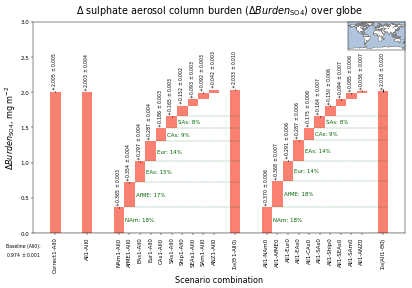

In [23]:
# Global sulphate aerosol burden
staggered_barcharts(variable='BURDENSO4', region='Globe',
                    text_format=r' {:+.3f} $\pm$ {:.3f} ',
                    ylim=[0, 3],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Written local/fS04.pdf


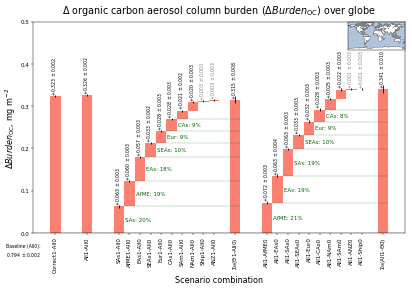

In [24]:
# Global organic carbon aerosol burden - supp figure
staggered_barcharts(variable='BURDENPOM', region='Globe',
                    text_format=r' {:+.3f} $\pm$ {:.3f} ',
                    ylim=[0, 0.5],
                    n_contributors='auto',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS05.pdf


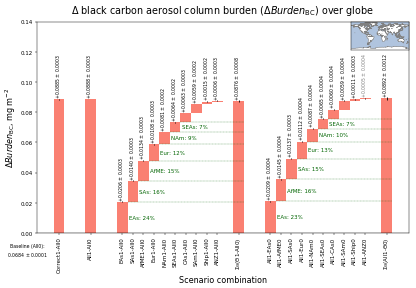

In [25]:
# Global black carbon aerosol burden - supp figure
staggered_barcharts(variable='BURDENBC', region='Globe',
                    text_format=r' {:+.4f} $\pm$ {:.4f} ',
                    ylim=[0, 0.14],
                    n_contributors='auto',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS06.pdf


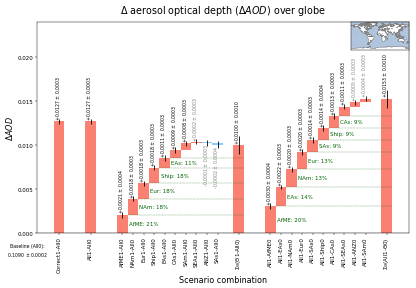

In [26]:
# Global AOD - supp figure
staggered_barcharts(variable='AEROD_v', region='Globe',
                    text_format=r' {:+.4f} $\pm$ {:.4f} ',
                    ylim=[0, 0.024],
                    n_contributors='auto',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/f03.pdf


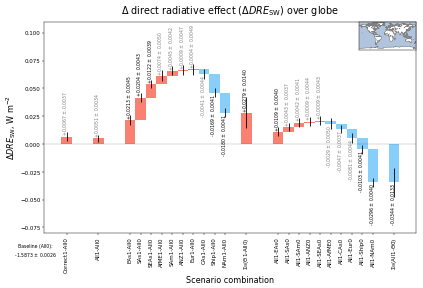

In [27]:
# Global DRE
staggered_barcharts(variable='FSNTOA-FSNTOA_d1', region='Globe',
                    text_format=r' {:+.4f} $\pm$ {:.4f} ',
                    ylim=[-0.08, 0.11],
                    n_contributors=0,
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Written local/fS07.pdf


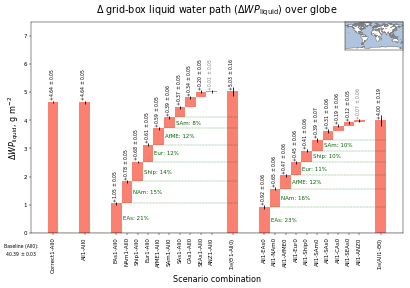

In [28]:
# Global liquid water path - supp figure
staggered_barcharts(variable='TGCLDLWP', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[0, 7.5],
                    n_contributors='auto',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS08.pdf


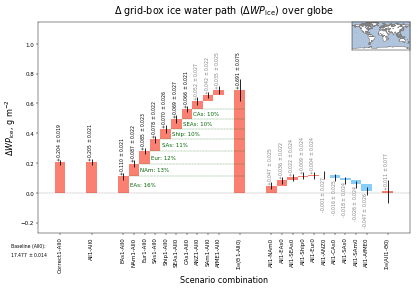

In [29]:
# Global ice water path - supp figure
staggered_barcharts(variable='TGCLDIWP', region='Globe',
                    text_format=r' {:+.3f} $\pm$ {:.3f} ',
                    ylim=[-0.27, 1.15],
                    n_contributors='auto',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/f04.pdf


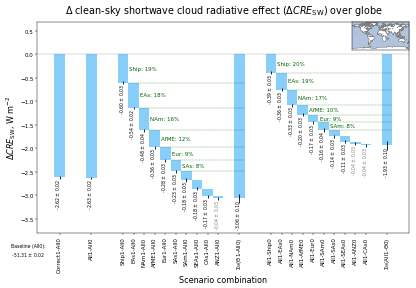

In [30]:
# Global SW CRE
staggered_barcharts(variable='SWCF_d1', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[-3.8, 0.7],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Written local/f05.pdf


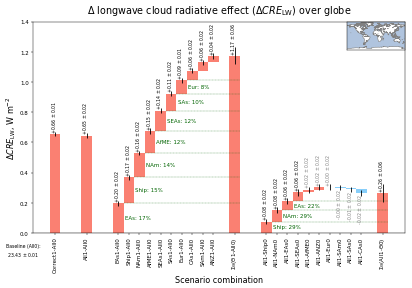

In [31]:
# Global LW CRE
staggered_barcharts(variable='LWCF', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[0, 1.4],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Written local/fS09.pdf


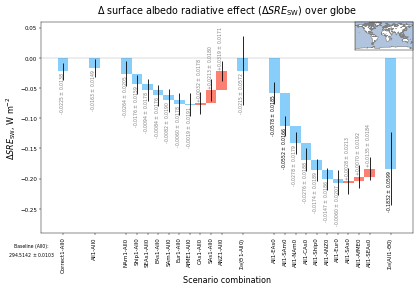

In [32]:
# Global SRE - supp figure
staggered_barcharts(variable='FSNTOAC_d1', region='Globe',
                    text_format=r' {:+.4f} $\pm$ {:.4f} ',
                    ylim=[-0.29, 0.06],
                    n_contributors=0,
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/f06.pdf


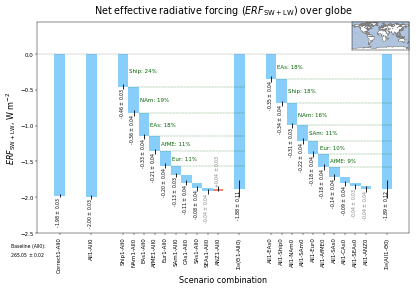

In [33]:
# Global net ERF
staggered_barcharts(variable='FSNTOA+LWCF', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[-2.5, 0.45],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

### Regional bar charts

Written local/f07a.pdf
Written local/f08a.pdf
Written local/f09a.pdf
Written local/f10a.pdf
Written local/f11a.pdf
Written local/f12a.pdf
Written local/f13a.pdf
Written local/f14a.pdf
Written local/f15a.pdf


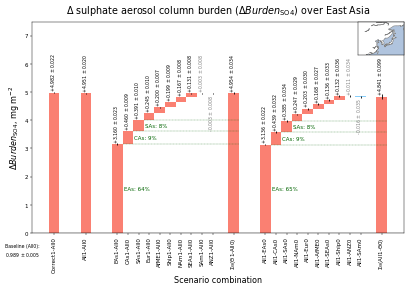

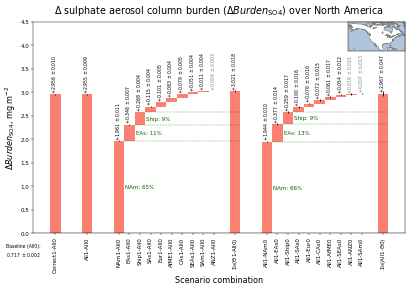

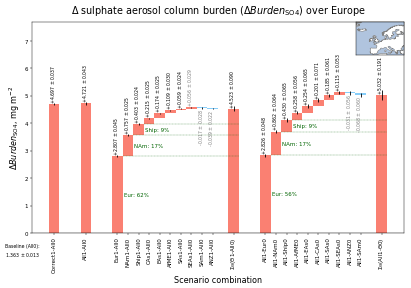

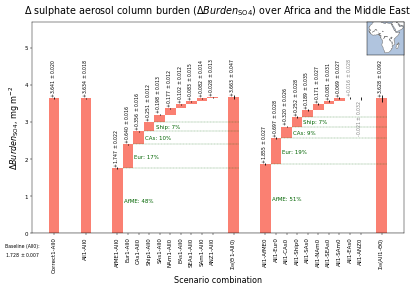

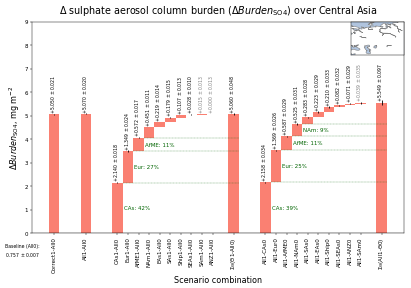

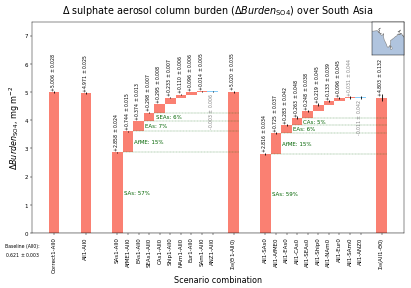

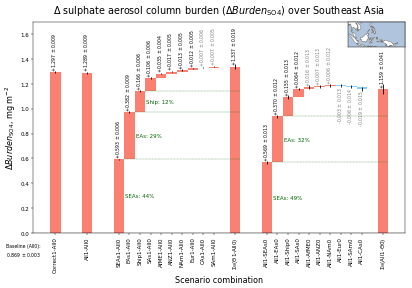

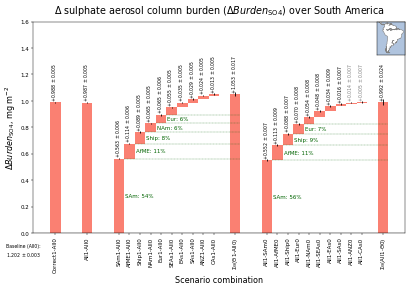

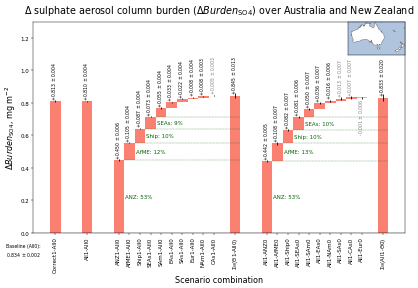

In [34]:
# Sulphate burdens for different regions - panel (a) of figures
original_figure_counter = figure_counter  # save current figure_counter value
for region, ylim, in {'EAs': [0, 7.5],
                      'NAm': [0, 4.5],
                      'Eur': [0, 7.7],
                      'AfME': [0, 5.7],
                      'CAs': [0, 9],
                      'SAs': [0, 7.5],
                      'SEAs': [0, 1.7],
                      'SAm': [0, 1.6],
                      'ANZ': [0, 1.3]
                     }.items():
    staggered_barcharts(variable='BURDENSO4', region=region,
                        text_format=r' {:+.3f} $\pm$ {:.3f} ',
                        ylim=ylim,
                        n_contributors='auto',
                        file_prefix='f{:02}a'.format(figure_counter))
    figure_counter += 1
figure_counter = original_figure_counter  # reset figure counter

Written local/f07b.pdf
Written local/f08b.pdf
Written local/f09b.pdf
Written local/f10b.pdf
Written local/f11b.pdf
Written local/f12b.pdf
Written local/f13b.pdf
Written local/f14b.pdf
Written local/f15b.pdf


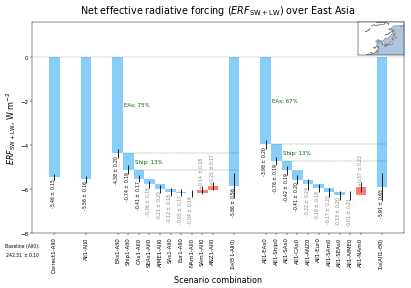

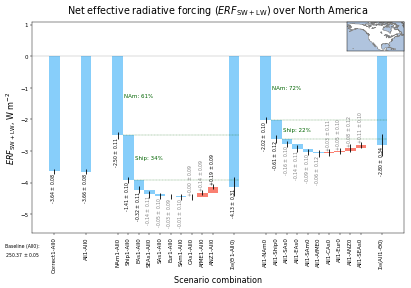

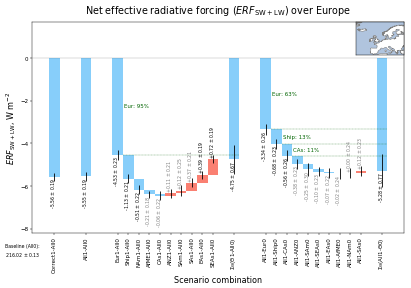

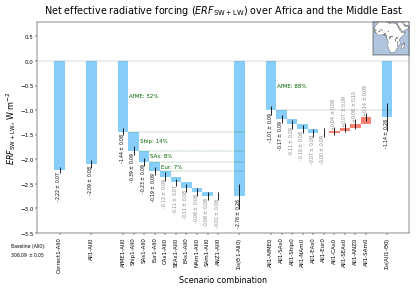

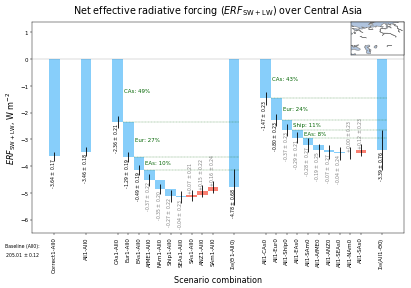

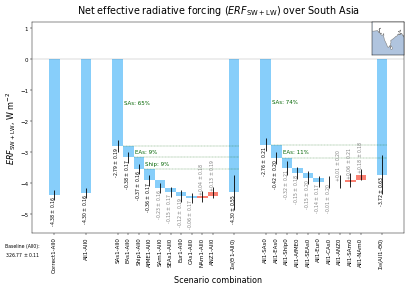

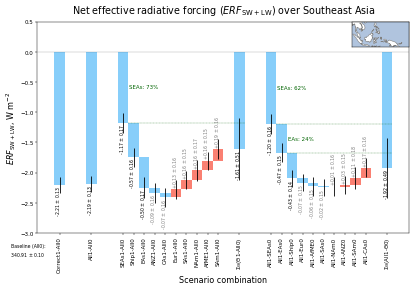

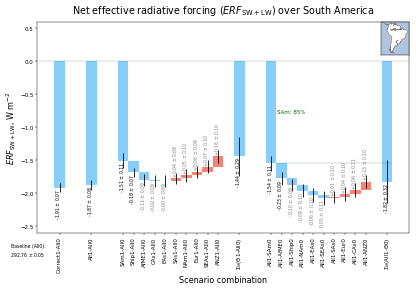

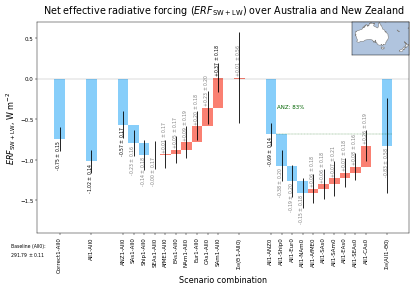

In [35]:
# Net ERF for different regions - panel (b) of figures
for region, ylim, in {'EAs': [-8, 1.6],
                      'NAm': [-5.6, 1.1],
                      'Eur': [-8.2, 1.7],
                      'AfME': [-3.5, 0.8],
                      'CAs': [-6.5, 1.4],
                      'SAs': [-5.6, 1.2],
                      'SEAs': [-3, 0.5],
                      'SAm': [-2.6, 0.6],
                      'ANZ': [-1.9, 0.7]
                     }.items():
    staggered_barcharts(variable='FSNTOA+LWCF', region=region,
                        text_format=r' {:+.2f} $\pm$ {:.2f} ',
                        ylim=ylim,
                        n_contributors='auto',
                        file_prefix='f{:02}b'.format(figure_counter))
    figure_counter += 1

In [36]:
! date

Thu Dec 28 17:59:03 +08 2017
